<a href="https://colab.research.google.com/github/AndresMontesDeOca/TimeSeries/blob/main/TP1_Ale_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP #1


In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller

# !pip install pmdarima
# !pip install pingouin
import pingouin as pg


# Ignorar las advertencias específicas de statsmodels
# from statsmodels.tools.sm_exceptions import ValueWarning
# warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore')

# Vamos a suprimir la notacion cientifica
pd.set_option("display.float_format", lambda x:"%.2f" %x)

Importamos la Serie

Como tenemos la serie en el Drive, tenemos que improtar una serie de librerias para poder levantar la serie

No olvidar dar los permisos al archivo para poder leer desde el jpynb el mismo.
Luego, copiamso la ruta al archivo, pero solo nos quedamos con el id para acceder al mismo, a continuacion se copia la ruta completa al archivo

https://drive.google.com/file/d/1cuyeVtIy_DOtiADp5cHwNsucJpzhaBqG/view?usp=share_link


Siempre que tenga que leer un archivo que esta en un drive, copiar esta ruta

In [26]:
# Code to read csv file into Colaboratory:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Air Pasangers
id = "1LV2t7HpwYpxSumUywyRE1wZ2xyF1KF5I"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('DemHoraria_v2.csv')
dataD = pd.read_csv("DemHoraria_v2.csv", sep=",") # Cargamos el Dataset
data = dataD
######################################################################
# Temperatura
id = "1Lji7usex9EBPQpTgUhAdI6oRnJN9pAxf"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('SerieT20_2022.csv')
dataT = pd.read_csv("SerieT20_2022.csv") # Cargamos el Dataset
######################################################################
# Demanda, Viento, Temperatura ya procesados y unidos en un solo DataFrame
id = "1Lk9Ib0cVa7vtsLXYjycjktIIhBzS3zdX"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('data_DTV.csv')
dataDVT = pd.read_csv("data_DTV.csv", parse_dates=['Fecha'], index_col='Fecha') # Cargamos el Dataset

## Tratamiento de Demanda y Viento

In [27]:
# Convertimos la columna "data_hora" a tipo de datos de fecha y hora
data["data_hora"]= pd.to_datetime(data["data_hora"], format="%Y-%m-%d %H")

# Renombramos las variables
data.rename(columns={"Demanda_MW": "Demanda", "data_hora":"Fecha", "Vel_viento": "Viento"}, inplace=True)

# Seteamos la Fecha como Index
data=data.set_index("Fecha")

# Filtrar los datos para los años 2020, 2021 y 2022
data = data['2020':'2022']

# Dividimos el DataFrame
dataD = data[['Demanda']]
dataV = data[['Viento']]

# display(data.head())
display(dataD.head())
display(dataV.head())

,Demanda
Fecha,
2020-01-01 00:00:00,1159.49
2020-01-01 01:00:00,1081.82
2020-01-01 02:00:00,1072.52
2020-01-01 03:00:00,1029.42
2020-01-01 04:00:00,979.26


,Viento
Fecha,
2020-01-01 00:00:00,20.10
2020-01-01 01:00:00,7.24
2020-01-01 02:00:00,10.90
2020-01-01 03:00:00,15.58
2020-01-01 04:00:00,13.30


## Tratamiento de Temperatura

In [28]:
dataT = dataT.dropna()

# Renombramos las variables
dataT.rename(columns={"TempAire": "Temperatura"}, inplace=True)

# Convertimos la columna "Fecha" a tipo de datos de fecha y hora
dataT["Fecha"]= pd.to_datetime(dataT["Fecha"], format='%m/%d/%Y %H:%M')

# Seteamos la Fecha como Index
dataT=dataT.set_index("Fecha")

display(dataT.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26277 entries, 2020-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperatura  26277 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB


None

En base a los valores anteriores, claramente hay datos atipicos en la base, en primer lugar no podemso tener valores negativos de demanda, vemos que el minimo es negativo y el maximo supera el pico de 2242 MW, todo lo que este fuera de este rango, son atipicos

# Union Datasets

In [29]:
# Comparar los índices de data1 y data3 para encontrar diferencias
differences = dataD.index.difference(dataT.index)

# Crear un nuevo DataFrame con los índices faltantes y todas las columnas en NaN
missing_indices = pd.DataFrame(index=differences)

# Unir este nuevo DataFrame con data3, manteniendo todos los valores de data3 y poniendo NaN en los valores faltantes
dataT = dataT.combine_first(missing_indices)

# Ordenar el DataFrame por el índice
dataT.sort_index(inplace=True)

# Comparar los índices de data1, data2 y data3 para verificar si son iguales
indices_equal = (dataD.index.equals(dataV.index) and dataV.index.equals(dataT.index))
print('Indices sincronizados:', indices_equal)

# Concatenacion, Todavia no, primero tengo que curar cara serie por separado
# data = pd.concat([dataD, dataV, dataT], axis=1)

print(pd.concat([dataD, dataV, dataT], axis=1).info())
display(pd.concat([dataD, dataV, dataT], axis=1).head())

Indices sincronizados: True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2020-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demanda      26304 non-null  float64
 1   Viento       26304 non-null  float64
 2   Temperatura  26277 non-null  float64
dtypes: float64(3)
memory usage: 1.8 MB
None


,Demanda,Viento,Temperatura
Fecha,,,
2020-01-01 00:00:00,1159.49,20.10,21.00
2020-01-01 01:00:00,1081.82,7.24,21.00
2020-01-01 02:00:00,1072.52,10.90,20.80
2020-01-01 03:00:00,1029.42,15.58,20.60
2020-01-01 04:00:00,979.26,13.30,20.60


# Preprocesamiento

## Tratamiento de Demanda

In [30]:
# Hacemos una descripcion del dataset
display(dataD.describe())

,Demanda
count,26304.00
mean,1288.26
std,248.15
min,676.16
25%,1100.52
50%,1279.12
75%,1442.94
max,9080.58


**Demanda**: Como ya se indico, es necesario evaluar los valores atipicos, como es una demanda electrica lo que estamos analizando, no es posible tener valores negativos, no tiene sentido fisico. Segun el minimo que figura en el analisis anterior, tenemos valores negativos.
Por otro lado, el pico de demanda maxima en el periodo analizado es 2300MW, por lo tanto, todo valor superior es atipico.

En este periodo tenemos un solo valor "0", el cual es un dato real, fue el corte del 19 de junio de 2019, corte que afecto a Argentina, Brazil y Uruguay, el valor que sigue en minimo es de 83MW.

In [31]:
# En basea a lo antes expuesto, vemos en que fechas tenemos los errores. Cotas establecidas [83, 2300]
display(data.query("Demanda> 2300 or Demanda<83"))


,Demanda,Viento
Fecha,,
2020-12-02 18:00:00,3365.14,2252.45
2021-10-20 00:00:00,2685.18,1426.07
2021-11-08 13:00:00,9080.58,20322.75


In [32]:
# # Calculamos la mediana general
# median_demand=data["Demanda"][data["Demanda"].between(83, 2300)].median()
# print("Mediana:", median_demand)

Si bien se plantea sustituir los valores extremos por la mediana, no es lo mas conveniente, dado que depende el momento del a;o y la hora donde esta el valor extremo, deberiamos sustituir el valor por el valor en la hora anterior o posterior al valor atipico. De todas formas, como ahora no se como hacerlo, continuo con el procedimiento que hizo Andres

In [33]:
# # Remplazo valores extremos y negativos por la media calculada
# data["Demanda"]= data["Demanda"].apply(lambda x:median_demand if x>2300 or x<83 else x)

Aca en lugar de reemplazar los valores fuera de rango por la Mediana general, primero los ponemos en Null, y luego aplicamos un Back-Fill

In [34]:
# Me parece que esto no es mas necesario, ya que al filtrar el dataset solo por los
# anos 2020, 2021, y 2022, nos quedamos sin valores atipicos

# Poniendo en nulos los valores menores a 83 o mayores a 2300
dataD['Demanda'] = dataD['Demanda'].apply(lambda x: x if (x >= 83 and x <= 2300) else None)

print('Cantidad de fuera de rango previa:', data.isnull().sum())

# Realizando backfill para llenar los valores nulos/fuera de rabgo
dataD['Demanda'].fillna(method='backfill', inplace=True)

print('Cantidad de fuera de rango post:', dataD.isnull().sum())

Cantidad de fuera de rango previa: Demanda    0
Viento     0
dtype: int64
Cantidad de fuera de rango post: Demanda    0
dtype: int64


In [35]:
# Hacemos otro describ para verificar la correccion de los errores
display(dataD.describe())

,Demanda
count,26304.00
mean,1287.85
std,242.99
min,676.16
25%,1100.52
50%,1279.10
75%,1442.89
max,2237.63


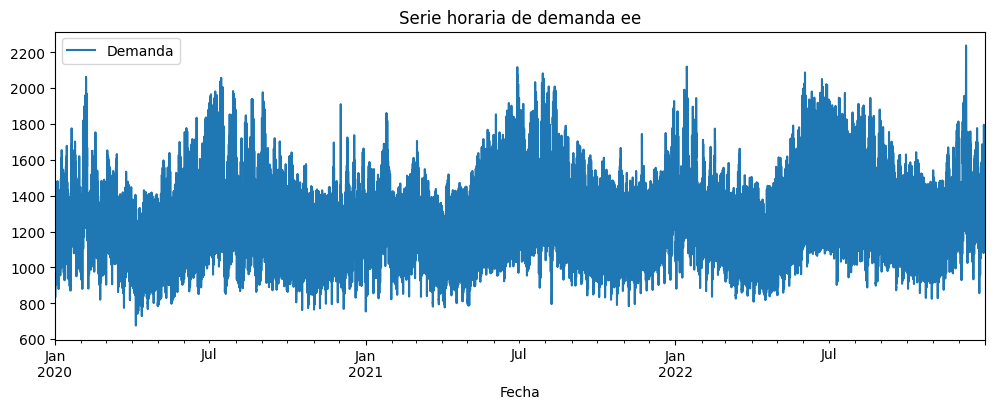

In [36]:
# Ploteamos para ver como queda la serie corregida
dataD.plot(title="Serie horaria de demanda ee", figsize=(12,4))
plt.show()

- Se siguen observando dos valores muy bajos, segurmente debamos modificar la cota inferior. Confirmarlo con Ale

Decidimos no agregar los valores por dia, y dejarlos atomizados por hora

In [37]:
# # Dado que el corte po rhora es muy atomizado, agregamos por dia
# data_daily=data["Demanda"].resample("D").sum()
# data_daily.plot(title="Serie agregada por Dia de demanda ee", figsize=(12,4))
# plt.show()


In [38]:
# # Seguimos con la variable data
# data=data_daily.to_frame() # Lo paso a Pandas DataFrame, sino me lo tranforma a Pandas Serie (No se porque se hizo este paso)

### Agregacion por dia

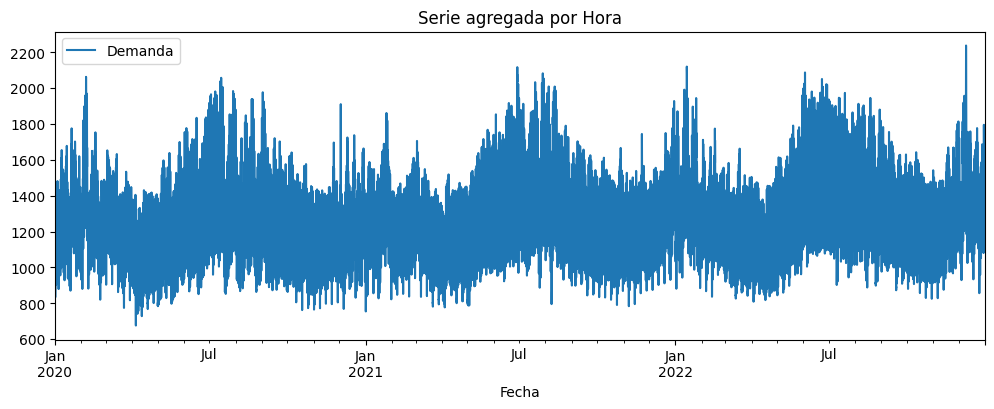

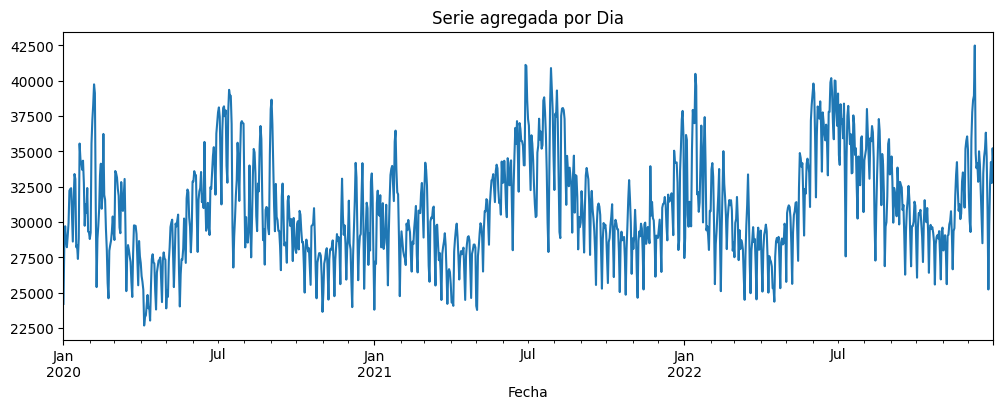

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2020-01-01 to 2022-12-31
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Demanda  1096 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB
None


In [39]:
# Tener el corte por hora no tiene mucho sentido para el Analisis
# Ademas, las notebook corren muy lento con tantos datos

# Ploteamos para ver como quedaria la serie corregida
dataD.plot(title='Serie agregada por Hora', figsize=(12, 4))
plt.show()

# El corte por hora es muy atomizado, agregamos por dia
dataD_daily = dataD['Demanda'].resample('D').sum()
dataD_daily.plot(title='Serie agregada por Dia', figsize=(12, 4))
plt.show()

# Seguimos con la variable data
dataD = dataD_daily.to_frame() # Lo paso a Pandas DataFrame, sino me lo transforma a Pandas
print(dataD.info())

## Tratamiento de Viento

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2020-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Viento  26304 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB
None
        Viento
count 26304.00
mean     20.24
std     127.58
min       0.00
25%       8.82
50%      15.29
75%      26.17
max   20322.75


<Axes: xlabel='Fecha'>

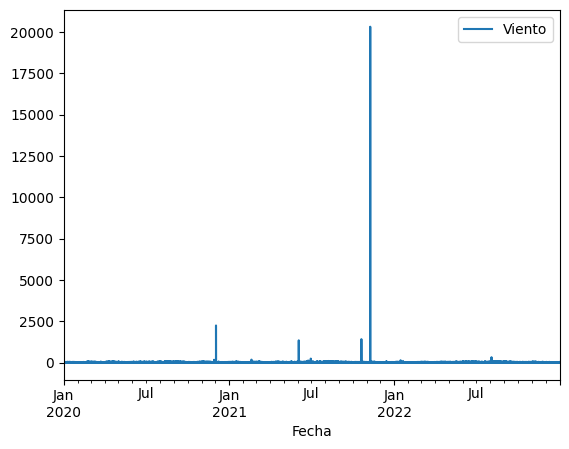

In [40]:
print(dataV.info())
print(dataV.describe())

dataV.plot()

<Axes: xlabel='Fecha'>

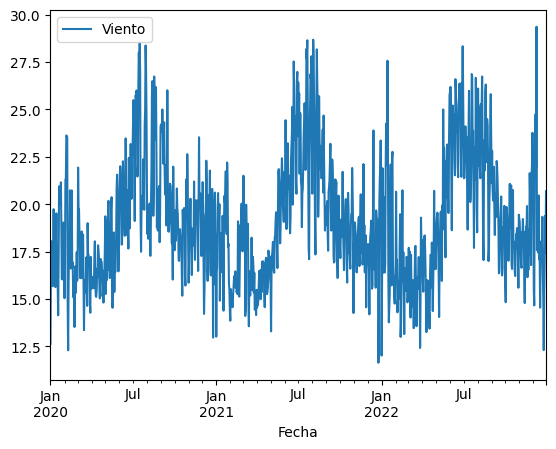

In [41]:
# Corregimos los valores rotos, ponemos en null los > a 100
dataV.loc[dataV['Viento'] > 100, 'Viento'] = None

# Completar los valores nulos con el método backfill en dataV_filtered
dataV.fillna(method='bfill', inplace=True)

# Calcular el promedio diario del viento
dataV = dataV.resample('D').mean()

# Verificar los cambios realizados
dataV.plot()

## Tratamiento de Temperatura

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2020-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperatura  26277 non-null  float64
dtypes: float64(1)
memory usage: 411.0 KB
None


<Axes: xlabel='Fecha'>

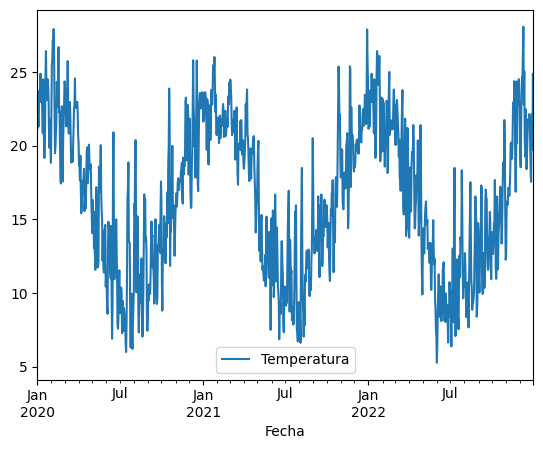

In [42]:
print(dataT.info())

# Completar los valores nulos con el método backfill
dataT.fillna(method='bfill', inplace=True)

# Agregar por Average o Maximo diario
dataT = dataT.resample('D').mean()

# Ploteamos
dataT.plot()

## Comparacion de las tres series unificadas

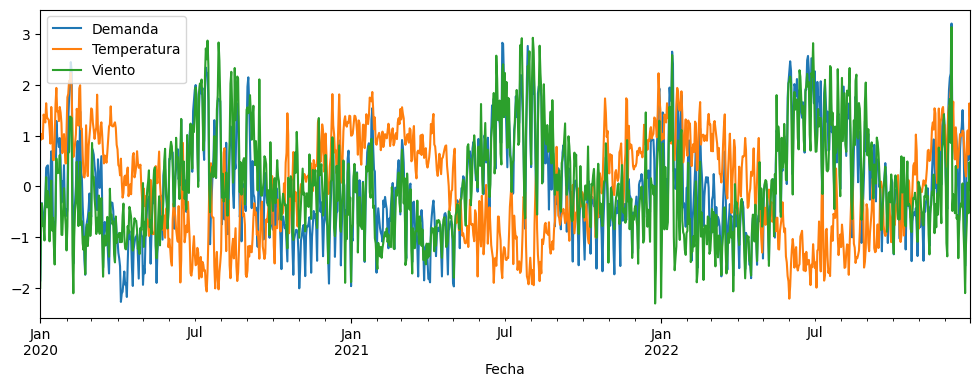

In [43]:
# Unificamos todas las Series en un Dataset
data = pd.concat([dataD, dataT, dataV], axis=1)

# Normalizamos para comprar las tres series en un solo plot
from scipy.stats import zscore

datN = data.apply(zscore)

datN.plot(figsize=(12, 4))
plt.show()

# Exportamos el Dataset curado
data.to_csv('data_DTV.csv', index=False)


- Pareciera ser que Demanda y Viento estan muy correlacionadas
- Tambien pareciera ser que la Demanda y la Temperatura estan inversamente relacionadas, osea que la Demanda de energia parece ser mayor el invierno, para calefaccionarse que en verano por el aire acondicionado

# Work in Progress 04/11

# Funciones Auxiliares

In [44]:
# Funciones Auxiliares para en Analsis Analitico de Diferenciacion

from pmdarima.arima import auto_arima, ndiffs, nsdiffs
from pmdarima.arima import ADFTest

def diferenciacion(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con KPSS test(MAIN)')
  print(n_kpss)


  print('Estimado de número de diferencias con ADF test')
  print(n_adf)

  print('Estimado de número de diferencias con PP test')
  print(n_pp)

  print('Se debe realizar diferenciación (should_diff) ADF Test')
  adftest = ADFTest(alpha=0.05)
  print(adftest.should_diff(y))

In [45]:
# Funciones Auxiliares para el Analisis Analitco de Estacionariedad
# Mepa que es lo mismo que ADFTest de  pmdarima

from statsmodels.tsa.stattools import adfuller

def estacioneriedad(y):
  resultado = adfuller(y)
  print('Estadistico ADF: %f' % resultado[0])
  print('p-valor: %f' % resultado[1])
  print('Valores criticos:')
  for key, valor in resultado[4].items():
    print('\t%s: %.3f' % (key, valor))

# Analisis de la Serie


## 2. Graficar las series originales

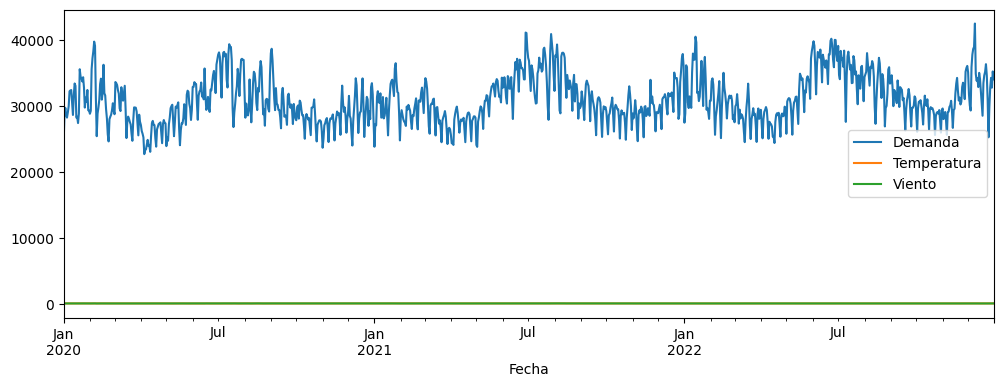

In [46]:
# Ploteamos la serie original

RRR

data.plot(figsize=(12, 4))
plt.show()

- Se siguen viendo dos valores atipicos a mediadios del 2017 y del 2019. Habria que revisar las cotas que nos dio el Negocio
- Sigo creyendo que nos conviene acumular los valores por dia en lugar de por hora, no se puede apreciar la serie sino

In [47]:
# Diferenciacion Analitica de la Serie original

diferenciacion(data)

ValueError: ignored

- Kwiatkowski-Phillips-Schmidt-Shin nos dice que debemos diferenciar una vez
- Agumented Dickey-Fuller y Phillips-Perron nos dicen que no es necesario
- Todavia no tomamos una decision acerca si conviene diferenciar o no

## 3. Graficar la FAS, FAC y FACP

In [ ]:
# Graficamos las Funciones de Autocorrelacion

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF y PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# ACF
plot_acf(data['Demanda'], ax=ax1, lags=50)
ax1.set_title('Autocorrelation Function')

# PACF
plot_pacf(data['Demanda'], ax=ax2, lags=50)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

- Del Grafico de Partial-Autocorrelacion (PACF) podemos concluir que la Serie tiene un pico en el lag 1, lo que indica que una Diferenciacion de Orden 1 es recomendable
- Del grarfico Autocorrelacion (ACF) concluimos que la Serie tiene un Trend decreciente, como asi tambien se observan unos valles, lo que indica tambien que la Serie puede tener un componente de Estacionalidad

## 4. Realizar distintas pruebas de raíces unitarias

In [ ]:
# Tests Analiticos de Diferenciacion

# !pip install -q arch
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

kpss_pvalue = kpss(data)[1]
adf_pvalue = adfuller(data)[1]
pp = PhillipsPerron(data)

print('p-values de los distintos test:\n')
print('KPSS (Kwiatkowski-Phillips-Schmidt-Shin)', kpss_pvalue)
print('Dickey-Fuller Aumentada (ADF):', np.round(adf_pvalue, 4), '\n')
print(pp)



- La H0 del test de KPSS indica la estacionariedad, la cual rechazamos con un p-value obtenido del 0.01%
- En cambio los tests de ADF y PP, con ambos p-values casi del 0%, rechazan la H0 de no-estacionariedad
- Los diferentes test nos arrojan valores contradictorios


## 5. Estimaciones con distintos parametros en SARIMA
PENDIENTE


In [ ]:
# Analizamos la descomposicion de la Serie

from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(14, 6))
seasonal_decompose(data['Demanda'], model='additive', period=12).plot()
plt.show()

- Se observa tanto Trend como Estacionalidad, la serie no es Estacionaria
- Es recomendable Diferenciar la serie de alguna manera, antes de aplicar SARIMA